# Feature Evolution with Phase

This notebook explore the evolution of feature pEW and velocities as a function of phase.


In [24]:
from pathlib import Path
from collections import OrderedDict

import sncosmo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sndata.csp import DR1, DR3
from sndata.utils import convert_to_jd
import yaml


In [ ]:
dr3 = DR3()
dr3.download_module_data()
project_dir = Path('.').resolve().parent 


## Reading in data

In [25]:
@np.vectorize
def get_csp_t0(obj_id):
    """Get the t0 value for CSP targets

    Args:
        obj_id (str): The object identifier

    Returns:
        The time of B-band maximum in units of
    """

    csp_table_3 = dr3.load_table(3).to_pandas(index='SN')
    
    # Unknown object ID
    if obj_id not in csp_table_3.index:
        return np.nan

    t0_mjd = csp_table_3.loc[obj_id]['T(Bmax)']

    # Known object Id with unknown peak time
    if np.isnan(t0_mjd):
        return np.nan

    return convert_to_jd(t0_mjd)


def read_in_pipeline_result(path, drop_flagged=False):
    """Read pEW values from analysis pipline file
    
    Adds columns for Branch classifications determined by the
    measured pEW values and spectral subtypes determined from 
    CSP DR1.
    
    Args:
        path (str): Path of the file to read
        
    Returns:
        A pandas Dataframe indexed by feat_name and obj_id
    """
    
    df = pd.read_csv(path, index_col=['feat_name', 'obj_id'])

    # Add phases using CSP DR3 t0 values
    obj_id = df.index.get_level_values(1)
    df['phase'] = df.time - get_csp_t0(obj_id)

    csp_table_2 = dr3.load_table(2)
    subtypes = pd.DataFrame({'spec_type': csp_table_2['Subtype1']}, index=csp_table_2['SN'])
    df = df.join(subtypes, on='obj_id')
    
    if drop_flagged:
        df = df[(df.spec_flag != 1) & (df.feat_flag != 1)]
    
    return df



In [27]:
results_dir = project_dir / 'results'
config_path = project_dir / 'app_config.yml'

with config_path.open() as infile:
    features = yaml.safe_load(infile)['features']

# Load CSP measurements and drop any flagged values
csp_final = read_in_pipeline_result(results_dir / 'final_csp.csv', drop_flagged=True)
csp_final = csp_final[~csp_final.spec_type.isin(('---', '06gz-like'))]
csp_final.head()


,,time,feat_start,feat_end,vel,vel_err,vel_samperr,pew,pew_err,pew_samperr,area,area_err,area_samperr,spec_flag,feat_flag,notes,phase,spec_type
feat_name,obj_id,,,,,,,,,,,,,,,,,
pW2,2004ef,2453255.66,3929.0819,4068.8654,NaN,0.0,NaN,12.432846,0.0,3.538539,7.091278e-15,0.0,2.246094e-15,0,0,NaN,-8.61,normal
pW3,2004ef,2453255.66,4068.8654,4464.1151,13176.598888,0.0,211.378099,86.793896,0.0,8.082350,5.371763e-14,0.0,6.300415e-15,0,0,NaN,-8.61,normal
pW4,2004ef,2453255.66,4526.7766,5066.6299,21673.924415,0.0,124.766254,169.348571,0.0,2.464627,8.934274e-14,0.0,1.772292e-15,0,0,NaN,-8.61,normal
pW5,2004ef,2453255.66,5155.8021,5601.6630,9043.079766,0.0,112.683776,81.630045,0.0,2.541775,2.970750e-14,0.0,1.135316e-15,0,0,NaN,-8.61,normal
pW6,2004ef,2453255.66,5601.6630,5840.2589,11669.096575,0.0,136.681639,26.028839,0.0,2.733116,7.720622e-15,0.0,9.188660e-16,0,0,NaN,-8.61,normal


## Pew Vs. Phase

In [28]:
def plot_feat_evolution(feature_data, plot_col='pew', color_by='spec_type', kwargs=dict(), axis=None):
    """Plot the strength of a feature vs phase
    
    Args:
        feature_data (DataFrame): Dataframe to plot data from
        plot_col           (str): Column to plot on the y axis 
        color_by           (str): Name of the column to color code points by
        kwargs      (dict[dict]): Plotting kwargs for each unique value in the `color_by` column
        axis              (Axis): Optionally plot on a given axis
    """
    
    if axis is None:
        fig, axis = plt.subplots(figsize=(6, 4))
    
    feature_data = feature_data.sort_values('phase')
    for i, (class_name, class_data) in enumerate(feature_data.groupby(color_by)):
        x = class_data.phase
        y = class_data[plot_col]
        y_err = class_data[plot_col + '_samperr']
        
        plot_kw = kwargs.get(class_name, dict())
        axis.errorbar(x, y, yerr=y_err, linestyle='', **plot_kw)
        axis.scatter(x, y, s=10, label=class_name,  **plot_kw)
    
    if axis is None:
        axis.set_xlabel('Phase', fontsize=12)
        axis.set_ylabel(r'pEW ($\AA$)', fontsize=12)
        
    axis.set_xlim(-15, 15)
    

In [30]:
def plot_all_features(df,  plot_col='pew', color_by='spec_type', kwargs=dict()):
    """Plot pEW measurments vs. phase for all 8 features
    
    Args:
        df      (DataFrame): Dataframe to plot data from
        plot_col           (str): Column to plot on the y axis 
        color_by      (str): Name of the column to color code points by
        kwargs (dict[dict]): Plotting kwargs for each unique value in the `color_by` column
    """
    
    plot_features = [f'pW{i}' for i in range(1, 9)]
    fig, axes = plt.subplots(4, 2, sharex=True, figsize=(7.5, 10))

    for axis, feature in zip(axes.flatten(), plot_features):
        feature_id = features[feature]['feature_id']
        axis.set_title(f'{feature_id} ({feature})')

        feature_data = df.loc[feature]
        plot_feat_evolution(
            feature_data, plot_col=plot_col,
            color_by=color_by, axis=axis, kwargs=kwargs)
        
    for axis in axes[:, 0]:
        axis.set_ylabel(plot_col, fontsize=12)
    
    for axis in axes[-1, :]:
        axis.set_xlabel('Phase', fontsize=12)
        
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), framealpha=1, bbox_to_anchor=(1.15, 1))
    
    plt.tight_layout()


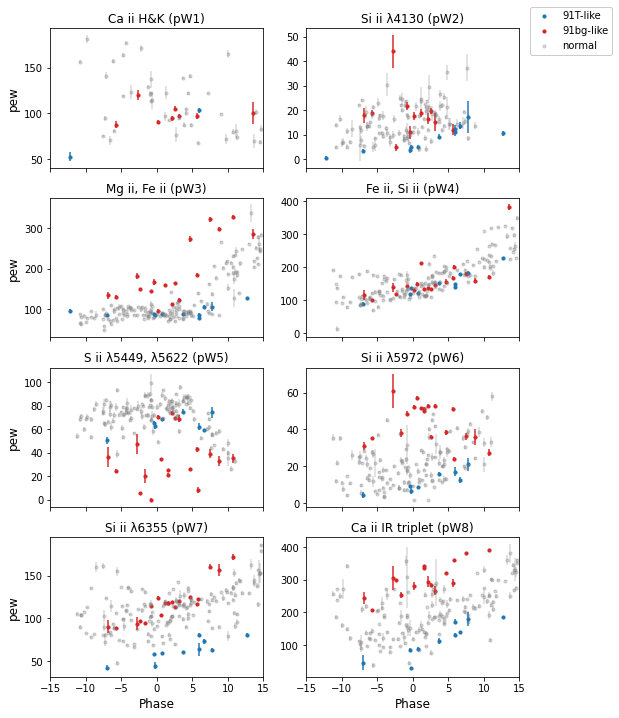

In [31]:
kwargs = {
    'normal': {'color': 'grey', 'alpha': .3},
    '91bg-like': {'color': 'C3'},
    '91T-like': {'color': 'C0'},
    '06gz-like': {'color': 'C1'}
}

plot_all_features(csp_final, kwargs=kwargs)
plt.show()


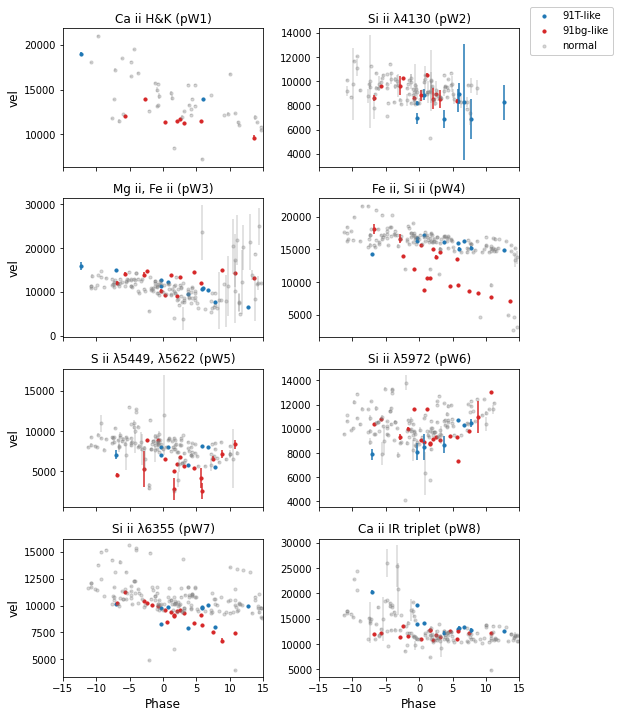

In [32]:
kwargs = {
    'normal': {'color': 'grey', 'alpha': .3},
    '91bg-like': {'color': 'C3'},
    '91T-like': {'color': 'C0'},
    '06gz-like': {'color': 'C1'}
}

plot_all_features(csp_final,'vel',  kwargs=kwargs)
plt.show()
